In [79]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error,mean_absolute_error

from sklearn.model_selection import StratifiedKFold
import  matplotlib.pyplot as plt
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt

In [80]:
# 常量定义
NFOLDS = 5  # 交叉验证的折数
SEQ_LEN = 5  # 序列长度
WINDOW_SIZE = 2 * SEQ_LEN  # 窗口长度
MODEL_N = 10  # 10个模型分别预测 CPU_USAGE_6...LAUNCHING_JOB_NUMS_10

__author__ = 'siliconx'
__version__ = '1.0.0'

pd.options.display.max_columns = None  # 展示所有列

In [81]:
# 初始数据
RAW_TRAIN = '../data/train.csv'
RAW_TEST = '../data/evaluation_public.csv'
SAMPLE_SUBMIT = '../data/submit_example.csv'

# 1. 加载数据

In [82]:
# 加载原始数据
train_df = pd.read_csv(RAW_TRAIN)
test_df = pd.read_csv(RAW_TEST)
# sample_df = pd.read_csv(SAMPLE_SUBMIT)

train_df = train_df.sort_values(by=['QUEUE_ID', 'DOTTING_TIME']).reset_index(drop=True)
test_df = test_df.sort_values(by=['ID', 'DOTTING_TIME']).reset_index(drop=True)

In [83]:
# display(train_df, test_df)

# 2. 预处理

In [84]:
def digitalization(fields):
    """将非数值型域转换为数值型."""
    # 组合训练集和测试集，只用来构建编码器，不用来训练模型
    df = pd.concat([train_df[fields], test_df[fields]], ignore_index=True)

    for f in fields:
        # 构建编码器
        le = LabelEncoder()
        le.fit(df[f])

        # 设置新值
        train_df[f] = le.transform(train_df[f])
        test_df[f] = le.transform(test_df[f])
        print('%s:' % f, le.classes_)

In [85]:
def pre_processing():
    """预处理."""
    print('Preprocessing...')

    # 缺失值填充
    # 经检验，为NaN的都是vm（通过QUEUE_ID查找）
    train_df['RESOURCE_TYPE'].fillna('vm', inplace=True)

    # 观察数据，填充0比较合理（NaN集中在数据前面，可能是由服务器尚未开始运行导致的）
    train_df['DISK_USAGE'].fillna(0, inplace=True)

    # 需要转换的列
    fields = ['STATUS', 'QUEUE_TYPE', 'PLATFORM', 'RESOURCE_TYPE']

    # 数值化
    digitalization(fields)

    # 重命名，原来的名字太长了
    for df in [train_df, test_df]:
        df.rename(columns={
            'LAUNCHING_JOB_NUMS': 'LJOB',
            'RUNNING_JOB_NUMS': 'RJOB',
            'SUCCEED_JOB_NUMS': 'SJOB',
            'CANCELLED_JOB_NUMS': 'CJOB',
            'FAILED_JOB_NUMS': 'FJOB'
        }, inplace=True)

In [86]:
%%time
pre_processing()


Preprocessing...
STATUS: ['assigned' 'assigning' 'available' 'suspended']
QUEUE_TYPE: ['general' 'spark' 'sql']
PLATFORM: ['aarch64' 'x86_64']
RESOURCE_TYPE: ['container' 'vm']
CPU times: user 382 ms, sys: 19.1 ms, total: 401 ms
Wall time: 443 ms


# 3. 特征工程

### 3.1 时间特征

-- 把DOTTINGTIME转换为一天之内的时间

In [87]:
for df in [train_df, test_df]:
    t = pd.to_datetime(df['DOTTING_TIME'], unit='ms')

    # 转成小时
    df['hour'] = t.dt.hour
    df['minute'] = t.dt.minute
    df['DOTTING_TIME'] = t.dt.hour + t.dt.minute / 60
#     df['DOTTING_TIME'] = t.dt.hour

In [88]:
train_df.head()

,QUEUE_ID,CU,STATUS,QUEUE_TYPE,PLATFORM,CPU_USAGE,MEM_USAGE,LJOB,RJOB,SJOB,CJOB,FJOB,DOTTING_TIME,RESOURCE_TYPE,DISK_USAGE,hour,minute
0,2,16,2,2,1,3,54,0,0,0,0,0,16.416667,1,20.0,16,25
1,2,16,2,2,1,2,54,0,0,0,0,0,16.500000,1,20.0,16,30
2,2,16,2,2,1,7,54,0,0,0,0,0,16.583333,1,20.0,16,35
3,2,16,2,2,1,4,54,0,0,0,0,0,16.666667,1,20.0,16,40
4,2,16,2,2,1,5,54,0,0,0,0,0,16.700000,1,20.0,16,42


### 3.2 行统计特征

In [89]:
%%time
used_features = ['CPU_USAGE', 'MEM_USAGE', 'DISK_USAGE', 'LJOB', 'RJOB']

# 分组，只用训练集数据做统计
group_data = train_df.groupby(by=['QUEUE_ID'])[used_features]

# 聚合函数
methods = {
    'AVG': 'mean',
    'MEDIAN': 'median',
    'MIN': 'min',
    'MAX': 'max',
    'STD': 'std',
}

for m in methods:
    agg_data = group_data.agg(methods[m])
    agg_data.fillna(method='ffill', inplace=True)
    agg_data.fillna(0, inplace=True)
    agg_data = agg_data.rename(lambda x: 'QUEUE_%s_%s' % (x, m), axis=1)
    agg_data = agg_data.reset_index()

    for df in [train_df, test_df]:
        merged_data = df[['QUEUE_ID']].merge(agg_data, how='left', on=['QUEUE_ID'])
        merged_data.drop(columns=['QUEUE_ID'], inplace=True)

        # 插入新的列
        for c in merged_data.columns:
            df[c] = 0

        # 赋值
        df.loc[:, list(merged_data.columns)] = merged_data.values

CPU times: user 2.13 s, sys: 763 ms, total: 2.89 s
Wall time: 3.16 s


###    3.3 滑动窗口构造数据集

In [90]:
# 需要滑动的数值特征
num_features = ['CPU_USAGE', 'MEM_USAGE', 'DISK_USAGE',
                'LJOB', 'RJOB', 'SJOB', 'CJOB', 'FJOB']

# 需要预测的值
y_features = ['CPU_USAGE', 'LJOB']

In [91]:
%%time
# 生成测试集时间窗数据
for i in range(SEQ_LEN): # 5
    for sf in num_features:
        new_f = '%s_%d' % (sf, i+1)
        test_df[new_f] = test_df[sf].shift(-i)

# 删除原来的列
test_df.drop(columns=num_features, inplace=True)

# 只取每个ID的第一条数据
test_df = test_df.groupby(by='ID', as_index=False).first()

CPU times: user 37.4 ms, sys: 0 ns, total: 37.4 ms
Wall time: 37.3 ms


In [92]:
%%time
# 生成训练集时间窗数据
temp = pd.DataFrame()
qids = sorted(train_df['QUEUE_ID'].unique())

for qid in tqdm(qids):  # 按QUEUE_ID进行处理
    queue = train_df[train_df['QUEUE_ID'] == qid].copy(deep=True)

    # 生成时间窗数据
    for i in range(SEQ_LEN):
        for sf in num_features:
            new_f = '%s_%d' % (sf, i+1)
            queue[new_f] = queue[sf].shift(-i)

    # 处理需要预测的值
    for i in range(SEQ_LEN):
        for y in y_features:
            new_y = '%s_%d' % (y, i+SEQ_LEN+1)
            queue[new_y] = queue[y].shift(-i-SEQ_LEN)

    # 删除原来的列
    queue.drop(columns=num_features, inplace=True)

    # 对于每个QUEUE_ID，丢弃最后10条有NAN值的数据
    queue = queue.head(queue.shape[0]-WINDOW_SIZE)
    temp = temp.append(queue)

# 重设索引
train_df = temp.reset_index(drop=True)

100%|██████████| 43/43 [00:12<00:00,  3.53it/s]


CPU times: user 6.52 s, sys: 5.37 s, total: 11.9 s
Wall time: 12.5 s


### 3.4 列统计特征

In [93]:
cpu_usages = []
mem_usages = []
disk_usages = []
ljobs = []
rjobs = []

for i in range(SEQ_LEN):  # 5 
    postfix = '_%d' % (i + 1)
    cpu_usages.append('CPU_USAGE'+postfix)
    mem_usages.append('MEM_USAGE'+postfix)
    disk_usages.append('DISK_USAGE'+postfix)
    ljobs.append('LJOB'+postfix)
    rjobs.append('RJOB'+postfix)

In [94]:
%%time
for df in [train_df, test_df]:
    # zheng.heng baseline给的特征
    df['USED_CPU'] = df['CU'] * df['CPU_USAGE_5'] / 100
    df['USED_MEM'] = 4 * df['CU'] * df['MEM_USAGE_5'] / 100
    df['TO_RUN_JOBS'] = df['LJOB_5'] - df['RJOB_5']
    df.loc[df['TO_RUN_JOBS'] < 0, 'TO_RUN_JOBS'] = 0

    # zheng.heng baseline中的新的列特征
    pairs = [
        ('CPU', 'CPU_USAGE', cpu_usages),
        ('MEM', 'MEM_USAGE', mem_usages),
        ('DISK', 'DISK_USAGE', disk_usages),
        ('LJOB', 'LJOB', ljobs),
        ('RJOB', 'RJOB', rjobs),
    ]

    for short_name, f, usages in pairs:
        df[short_name+'_AVG'] = df[usages].mean(axis=1)
        df[short_name+'_STD'] = df[usages].std(axis=1)
        df[short_name+'_MAX'] = df[usages].max(axis=1)
        df[short_name+'_DIFF'] = df['%s_5' % f] - df['%s_1' % f]
        
        
    df['delta_CPU_AVG_CPU_USAGE_5'] = df['CPU_AVG'] - df['CPU_USAGE_5']
    df['delta_CPU_AVG_CPU_USAGE_MAX'] = df['CPU_AVG'] - df['CPU_MAX']       

CPU times: user 1.72 s, sys: 1.67 s, total: 3.39 s
Wall time: 3.61 s


In [95]:
train_df.columns[-20:]

Index(['CPU_MAX', 'CPU_DIFF', 'MEM_AVG', 'MEM_STD', 'MEM_MAX', 'MEM_DIFF',
       'DISK_AVG', 'DISK_STD', 'DISK_MAX', 'DISK_DIFF', 'LJOB_AVG', 'LJOB_STD',
       'LJOB_MAX', 'LJOB_DIFF', 'RJOB_AVG', 'RJOB_STD', 'RJOB_MAX',
       'RJOB_DIFF', 'delta_CPU_AVG_CPU_USAGE_5',
       'delta_CPU_AVG_CPU_USAGE_MAX'],
      dtype='object')

# 滑窗统计特征

In [96]:
# # 行内统计特征
# # 行内统计特征
# def stat_feat(data,step,col):
# #     print(step)
#     data['mean'+col+'_'+str(step)] = data[[f'{col}_{i}' for i in range(1,step+1)]].mean(axis=1)
#     data['std'+col+'_'+str(step)] = data[[f'{col}_{i}' for i in range(1,step+1)]].std(axis=1)
#     data['max'+col+'_'+str(step)] = data[[f'{col}_{i}' for i in range(1,step+1)]].max(axis=1)
#     data[f'{col}_{step+1}_'+'mean'+col+'_'+str(step)] = data[f'{col}_{step+1}'] - data['mean'+col+'_'+str(step)]
#     data['max'+col+'_'+str(step)+'mean'+col+'_'+str(step)] = data['max'+col+'_'+str(step)] - data['mean'+col+'_'+str(step)]

#     #     if step < 6:
# #         data['diff_1'+col+'_'+str(step)] = data[f'{col}_{step}'] - data[f'{col}_1']
# #         if step  > 2:
# #             data['diff_2'+col+'_'+str(step)] = data[f'{col}_{step}'] - data[f'{col}_2']
# #         if step > 3:    
# #             data['diff_3'+col+'_'+str(step)] = data[f'{col}_{step}'] - data[f'{col}_3']
# #         if step > 4:   
# #             data['diff_4'+col+'_'+str(step)] = data[f'{col}_{step}'] - data[f'{col}_4']

# #     if (step >1) & (step < 6):
# #         data['diff'+col+str(step)+str(step-1)] = data[f'{col}_{step}'] - data[f'{col}_{step-1}']
#     return data    

def stat_feat(data,step,col):
#     print(step)
    data['mean'+col+'_'+str(step)] = data[[f'{col}_{i}' for i in range(1,step)]].mean(axis=1)
    data['std'+col+'_'+str(step)] = data[[f'{col}_{i}' for i in range(1,step)]].std(axis=1)
    data['max'+col+'_'+str(step)] = data[[f'{col}_{i}' for i in range(1,step)]].max(axis=1)
    if step < 6:
        data['diff_1'+col+'_'+str(step)] = data[f'{col}_{step}'] - data[f'{col}_1']
        if step  > 2:
            data['diff_2'+col+'_'+str(step)] = data[f'{col}_{step}'] - data[f'{col}_2']
        if step > 3:    
            data['diff_3'+col+'_'+str(step)] = data[f'{col}_{step}'] - data[f'{col}_3']
        if step > 4:   
            data['diff_4'+col+'_'+str(step)] = data[f'{col}_{step}'] - data[f'{col}_4']

    if (step >1) & (step < 6):
        data['diff'+col+str(step)+str(step-1)] = data[f'{col}_{step}'] - data[f'{col}_{step-1}']
    return data   
#,'LJOB','RJOB','SJOB','CJOB', 'FJOB',
for c in tqdm(['MEM_USAGE','CPU_USAGE','DISK_USAGE']):
    for s in range(2,5):
        train_df = stat_feat(train_df,s,c)
        test_df = stat_feat(test_df,s,c)


100%|██████████| 3/3 [00:09<00:00,  3.02s/it]


### 3.5 特征过滤

In [97]:
# 去掉无用列 'QUEUE_ID',
useless = [ 
     'PLATFORM', 'RESOURCE_TYPE', 'STATUS',
]

train_df.drop(columns=useless, inplace=True)
test_df.drop(columns=useless, inplace=True)
# ['ID']+
# display(train_df, test_df)

In [98]:
# to_drop = []

# for col in train_df.columns:
#     t = train_df[col].value_counts().sort_values(ascending=False)
#     if len(t) == 1 or list(t)[0]/len(train_df)>0.99:
#         to_drop.append(col)
# train_df.drop(columns=to_drop, inplace=True)
# test_df.drop(columns=to_drop, inplace=True)
# len(test_df)
test_df.head()

,ID,QUEUE_ID,CU,QUEUE_TYPE,DOTTING_TIME,hour,minute,QUEUE_CPU_USAGE_AVG,QUEUE_MEM_USAGE_AVG,QUEUE_DISK_USAGE_AVG,QUEUE_LJOB_AVG,QUEUE_RJOB_AVG,QUEUE_CPU_USAGE_MEDIAN,QUEUE_MEM_USAGE_MEDIAN,QUEUE_DISK_USAGE_MEDIAN,QUEUE_LJOB_MEDIAN,QUEUE_RJOB_MEDIAN,QUEUE_CPU_USAGE_MIN,QUEUE_MEM_USAGE_MIN,QUEUE_DISK_USAGE_MIN,QUEUE_LJOB_MIN,QUEUE_RJOB_MIN,QUEUE_CPU_USAGE_MAX,QUEUE_MEM_USAGE_MAX,QUEUE_DISK_USAGE_MAX,QUEUE_LJOB_MAX,QUEUE_RJOB_MAX,QUEUE_CPU_USAGE_STD,QUEUE_MEM_USAGE_STD,QUEUE_DISK_USAGE_STD,QUEUE_LJOB_STD,QUEUE_RJOB_STD,CPU_USAGE_1,MEM_USAGE_1,DISK_USAGE_1,LJOB_1,RJOB_1,SJOB_1,CJOB_1,FJOB_1,CPU_USAGE_2,MEM_USAGE_2,DISK_USAGE_2,LJOB_2,RJOB_2,SJOB_2,CJOB_2,FJOB_2,CPU_USAGE_3,MEM_USAGE_3,DISK_USAGE_3,LJOB_3,RJOB_3,SJOB_3,CJOB_3,FJOB_3,CPU_USAGE_4,MEM_USAGE_4,DISK_USAGE_4,LJOB_4,RJOB_4,SJOB_4,CJOB_4,FJOB_4,CPU_USAGE_5,MEM_USAGE_5,DISK_USAGE_5,LJOB_5,RJOB_5,SJOB_5,CJOB_5,FJOB_5,USED_CPU,USED_MEM,TO_RUN_JOBS,CPU_AVG,CPU_STD,CPU_MAX,CPU_DIFF,MEM_AVG,MEM_STD,MEM_MAX,MEM_DIFF,DISK_AVG,DISK_STD,DISK_MAX,DISK_DIFF,LJOB_AVG,LJOB_STD,LJOB_MAX,LJOB_DIFF,RJOB_AVG,RJOB_STD,RJOB_MAX,RJOB_DIFF,delta_CPU_AVG_CPU_USAGE_5,delta_CPU_AVG_CPU_USAGE_MAX,meanMEM_USAGE_2,stdMEM_USAGE_2,maxMEM_USAGE_2,diff_1MEM_USAGE_2,diffMEM_USAGE21,meanMEM_USAGE_3,stdMEM_USAGE_3,maxMEM_USAGE_3,diff_1MEM_USAGE_3,diff_2MEM_USAGE_3,diffMEM_USAGE32,meanMEM_USAGE_4,stdMEM_USAGE_4,maxMEM_USAGE_4,diff_1MEM_USAGE_4,diff_2MEM_USAGE_4,diff_3MEM_USAGE_4,diffMEM_USAGE43,meanCPU_USAGE_2,stdCPU_USAGE_2,maxCPU_USAGE_2,diff_1CPU_USAGE_2,diffCPU_USAGE21,meanCPU_USAGE_3,stdCPU_USAGE_3,maxCPU_USAGE_3,diff_1CPU_USAGE_3,diff_2CPU_USAGE_3,diffCPU_USAGE32,meanCPU_USAGE_4,stdCPU_USAGE_4,maxCPU_USAGE_4,diff_1CPU_USAGE_4,diff_2CPU_USAGE_4,diff_3CPU_USAGE_4,diffCPU_USAGE43,meanDISK_USAGE_2,stdDISK_USAGE_2,maxDISK_USAGE_2,diff_1DISK_USAGE_2,diffDISK_USAGE21,meanDISK_USAGE_3,stdDISK_USAGE_3,maxDISK_USAGE_3,diff_1DISK_USAGE_3,diff_2DISK_USAGE_3,diffDISK_USAGE32,meanDISK_USAGE_4,stdDISK_USAGE_4,maxDISK_USAGE_4,diff_1DISK_USAGE_4,diff_2DISK_USAGE_4,diff_3DISK_USAGE_4,diffDISK_USAGE43
0,1,297,16,2,13.950000,13,57,22.605079,57.987538,7.341295,0.563350,3.372734,4.0,60.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,97.0,9.0,79.0,49.0,33.306008,11.125508,2.508640,3.648205,7.763952,60,69,9,0,5,5,0,0,58.0,69.0,9.0,0.0,9.0,4.0,0.0,0.0,80.0,67.0,9.0,0.0,9.0,1.0,0.0,0.0,100.0,65.0,9.0,0.0,7.0,2.0,0.0,1.0,98.0,67.0,9.0,0.0,10.0,3.0,0.0,1.0,15.68,42.88,0.0,79.2,20.029978,100.0,38.0,67.4,1.673320,69.0,-2.0,9.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,8.0,2.000000,10.0,5.0,-18.8,-20.8,69.0,NaN,69,0.0,0.0,69.0,0.000000,69.0,-2.0,-2.0,-2.0,68.333333,1.154701,69.0,-4.0,-4.0,-2.0,-2.0,60.0,NaN,60,-2.0,-2.0,59.0,1.414214,60.0,20.0,22.0,22.0,66.000000,12.165525,80.0,40.0,42.0,20.0,20.0,9.0,NaN,9,0.0,0.0,9.0,0.0,9.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,0.0,0.0,0.0
1,2,85153,64,0,13.766667,13,46,12.290532,30.926566,19.998607,0.431896,1.634362,7.0,30.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99.0,99.0,20.0,147.0,49.0,14.911072,12.356762,0.166939,4.136347,5.374643,56,91,20,0,0,0,0,0,48.0,78.0,20.0,0.0,1.0,1.0,0.0,0.0,23.0,35.0,20.0,0.0,0.0,0.0,0.0,0.0,68.0,61.0,20.0,0.0,0.0,0.0,0.0,0.0,38.0,74.0,20.0,0.0,0.0,0.0,0.0,0.0,24.32,189.44,0.0,46.6,17.169741,68.0,-18.0,67.8,21.229696,91.0,-17.0,20.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.2,0.447214,1.0,0.0,8.6,-21.4,91.0,NaN,91,-13.0,-13.0,84.5,9.192388,91.0,-56.0,-43.0,-43.0,68.000000,29.308702,91.0,-30.0,-17.0,26.0,26.0,56.0,NaN,56,-8.0,-8.0,52.0,5.656854,56.0,-33.0,-25.0,-25.0,42.333333,17.214335,56.0,12.0,20.0,45.0,45.0,20.0,NaN,20,0.0,0.0,20.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,20.0,0.0,0.0,0.0,0.0
2,3,297,16,2,12.816667,12,49,22.605079,57.987538,7.341295,0.563350,3.372734,4.0,60.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,97.0,9.0,79.0,49.0,33.306008,11.125508,2.508640,3.648205,7.763952,2,41,9,0,6,1,0,2,5.0,42.0,9.0,0.0,6.0,2.0,0.0,1.0,3.0,43.0,9.0,0.0,6.0,3.0,0.0,0.0,80.0,68.0,9.0,0.0,8.0,2.0,0.0,0.0,90.0,82.0,9.0,0.0,8.0,2.0,0.0,0.0,14.40,52.48,0.0,36.0,44.883182,90.0,88.0,55.2,18.753666,82.0,41.0,9.0,0.0,9.0,0.0,0.0,0.0,0.0,0.

In [120]:
# feat_column

In [121]:
feat_column = list(filter(lambda x: x not in [f'cpu_{i}' for i in range(1,6)], test_df.columns )) 
# feat_column.append('ID')
new_test = pd.DataFrame()
for j in range(6,11):  
    tmp = test_df[feat_column]
#     tmp['time'] = j-5
    tmp['minute'] += 5*(j-6)
    tmp['hour'] += (5/60)*(j-6)
    #   tmp.rename(columns={f'cpu_{j}': 'cpu'},inplace=True)
    new_test = pd.concat([new_test,tmp]).reset_index(drop=True)

In [53]:
feat_column = list(filter(lambda x: x not in [f'CPU_USAGE_{i}' for i in range(6,11)], train_df.columns )) 
new_train = pd.DataFrame()
for j in range(6,11):
    tmp = train_df[feat_column+[f'CPU_USAGE_{j}']]
    # minute DOTTING_TIME
    tmp['minute'] += 5*(j-6)
    tmp['hour'] += (5/60)*(j-6)
#     tmp['time'] = j-5
    tmp.rename(columns={f'CPU_USAGE_{j}': 'cpu'},inplace=True)
    new_train = pd.concat([new_train,tmp]).reset_index(drop=True)

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/root/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

In [54]:
set(new_train.columns)-set(new_test.columns)

{'LJOB_10', 'LJOB_6', 'LJOB_7', 'LJOB_8', 'LJOB_9', 'cpu'}

In [55]:
new_train.drop(columns=['LJOB_10', 'LJOB_6', 'LJOB_7', 'LJOB_8', 'LJOB_9'],inplace=True)

In [56]:
new_train_c = new_train.copy()

In [136]:
new_test_c = new_test.copy()

In [137]:
new_train = new_train_c[new_train_c.QUEUE_ID == 297]
new_test = new_test_c[new_test_c.QUEUE_ID == 297]

In [138]:
trn_col = [i for i in new_train.columns if (i != 'cpu')&(i!='QUEUE_ID')]


[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 33.6367	valid_1's l2: 49.1956
[400]	training's l2: 27.3551	valid_1's l2: 47.7101
[600]	training's l2: 23.3094	valid_1's l2: 46.9044
[800]	training's l2: 20.2899	valid_1's l2: 46.5048
[1000]	training's l2: 17.7407	valid_1's l2: 46.1343
[1200]	training's l2: 15.8116	valid_1's l2: 45.9313
[1400]	training's l2: 14.2138	valid_1's l2: 45.7756
Early stopping, best iteration is:
[1439]	training's l2: 13.9332	valid_1's l2: 45.7403


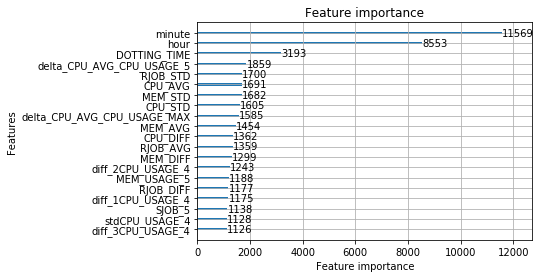

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 33.3127	valid_1's l2: 47.1918
[400]	training's l2: 26.8571	valid_1's l2: 45.698
[600]	training's l2: 23.1048	valid_1's l2: 45.4396
[800]	training's l2: 19.5874	valid_1's l2: 44.9862
Early stopping, best iteration is:
[840]	training's l2: 18.9905	valid_1's l2: 44.8566


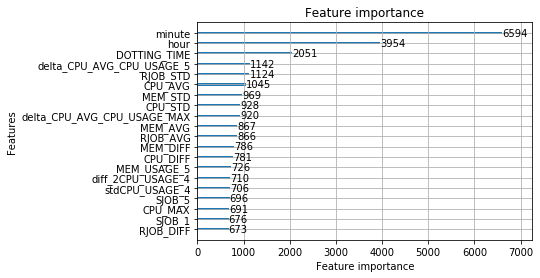

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 33.6385	valid_1's l2: 48.2991
[400]	training's l2: 26.6869	valid_1's l2: 46.7153
[600]	training's l2: 22.6075	valid_1's l2: 46.1738
Early stopping, best iteration is:
[618]	training's l2: 22.1706	valid_1's l2: 46.1018


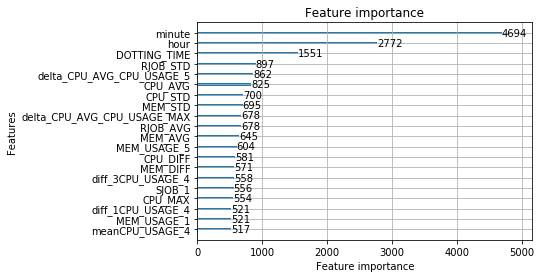

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 33.5122	valid_1's l2: 48.8866
[400]	training's l2: 26.7559	valid_1's l2: 47.0762
[600]	training's l2: 22.7435	valid_1's l2: 46.3578
[800]	training's l2: 19.517	valid_1's l2: 45.6339
Early stopping, best iteration is:
[834]	training's l2: 19.182	valid_1's l2: 45.6243


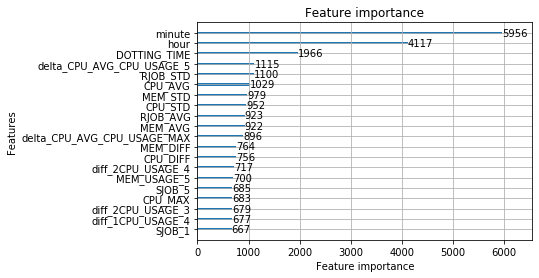

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 33.4119	valid_1's l2: 48.7121
[400]	training's l2: 26.5714	valid_1's l2: 47.1105
[600]	training's l2: 22.5093	valid_1's l2: 46.221
[800]	training's l2: 19.2704	valid_1's l2: 45.7059
[1000]	training's l2: 17.1539	valid_1's l2: 45.5701
Early stopping, best iteration is:
[1131]	training's l2: 15.7932	valid_1's l2: 45.4046


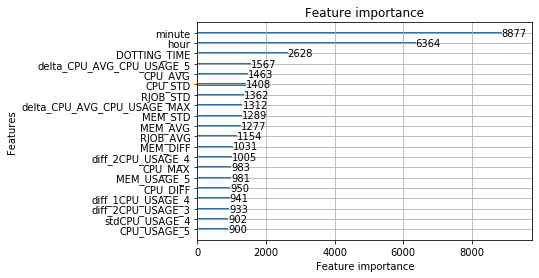

score_mse= 45.49527722678757


In [139]:
lgb_param = {
    'num_leaves': 64,
    'max_depth': 10,
    'learning_rate': 0.08,
    'n_estimators': 2000,
    'subsample': 0.6,
    'feature_fraction': 0.6,
    'reg_alpha': 0.6,
    'reg_lambda': 1.2,
    'seed': 2020  # ！！！记得修改！！！
}
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
oof = np.zeros((new_train.shape[0]))
oof_test = np.zeros((new_test.shape[0]))

for fold_id, ( train_idx, validate_idx) in enumerate(kfold.split(new_train, new_train['cpu'])):
# for train_idx, validate_idx in kf:
#         print( X_train)
    # 切割训练集&验证集
    X_train, y_train = new_train[trn_col].iloc[train_idx, :], new_train['cpu'].iloc[train_idx]
    X_valid, y_valid = new_train[trn_col].iloc[validate_idx, :], new_train['cpu'].iloc[validate_idx]

    reg = lgb.LGBMRegressor(n_jobs=-1, **lgb_param)
    bst = reg.fit(X_train, y_train, verbose=200, eval_set=[(X_train, y_train),(X_valid, y_valid)],
                  early_stopping_rounds=50)

    # 特征重要性
    lgb.plot_importance(bst, max_num_features=20)
    plt.show()
    # 验证集
    valid_pred = bst.predict(X_valid)
    valid_pred[valid_pred < 0] = 0
    valid_pred[valid_pred > 100] = 100
    valid_pred = valid_pred.astype(np.int)
    oof[validate_idx] = valid_pred

    # 测试集
    test_pred = bst.predict(new_test[trn_col])
    test_pred[test_pred < 0] = 0
    test_pred[test_pred > 100] = 100
    oof_test += test_pred / NFOLDS
score_mse = mean_squared_error(new_train['cpu'], oof)
print('score_mse=',score_mse)

In [143]:
test_res = new_test[['ID','QUEUE_ID']].copy()
test_res['cpu'] = oof_test
test_res.head()

,ID,QUEUE_ID,cpu
0,1,297,93.994983
2,3,297,46.793803
3,4,297,18.965132
6,7,297,7.396030
10,11,297,3.479672


In [151]:
len(test_res)/5

1142.0

In [164]:
#  test_res[part_len:part_len*2]

In [ ]:
part_len = int(len(test_res)/5)
tmp = test_res[:part_len]
tmp['cpu_2'] = test_res[part_len:part_len*2]['cpu'].values
tmp['cpu_3'] = test_res[part_len*2:part_len*3]['cpu'].values
tmp['cpu_4'] = test_res[part_len*3:part_len*4]['cpu'].values
tmp['cpu_5'] = test_res[part_len*4:part_len*5]['cpu'].values
tmp

In [163]:
# tmp.to_csv('./297.csv',index=False)
tmp

,ID,QUEUE_ID,cpu,cpu_2,cpu_3,cpu_4,cpu_5
0,1,297,93.994983,89.225031,87.704879,83.158975,82.495532
2,3,297,46.793803,56.507071,29.516274,17.532883,12.586358
3,4,297,18.965132,3.768096,4.017536,2.462781,2.134772
6,7,297,7.396030,6.927811,5.469104,4.821766,5.500818
10,11,297,3.479672,3.131996,11.250468,66.070707,73.144237
...,...,...,...,...,...,...,...
2984,2985,297,58.292840,58.058702,33.389575,37.232139,12.934262
2986,2987,297,27.656654,8.569011,6.051013,4.970694,5.038128
2987,2988,297,75.129030,52.739349,45.328595,19.337415,8.727138
2991,2992,297,1.648895,1.809134,3.208812,47.027471,79.695540


In [161]:
k = pd.read_csv('./335.csv')
k[k.ID.isin(tmp.ID)]

,ID,CPU_USAGE_1,LAUNCHING_JOB_NUMS_1,CPU_USAGE_2,LAUNCHING_JOB_NUMS_2,CPU_USAGE_3,LAUNCHING_JOB_NUMS_3,CPU_USAGE_4,LAUNCHING_JOB_NUMS_4,CPU_USAGE_5,LAUNCHING_JOB_NUMS_5
0,1,85,0,88,0,92,0,79,0,94,0
2,3,58,0,74,0,23,0,11,0,3,0
3,4,17,0,20,0,8,0,3,0,4,0
6,7,10,0,10,0,6,0,0,0,6,0
10,11,3,0,6,0,9,0,52,0,58,0
...,...,...,...,...,...,...,...,...,...,...,...
2984,2985,51,0,53,0,32,0,29,0,22,0
2986,2987,32,0,13,0,4,0,5,0,3,0
2987,2988,75,0,55,0,30,0,4,0,1,0
2991,2992,1,0,1,0,2,0,44,0,75,0


# 4. 训练&预测

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 24.0073	valid_1's l2: 25.1127
[400]	training's l2: 21.8265	valid_1's l2: 23.7844
[600]	training's l2: 20.4564	valid_1's l2: 23.1015
[800]	training's l2: 19.427	valid_1's l2: 22.6723
[1000]	training's l2: 18.6179	valid_1's l2: 22.3656
[1200]	training's l2: 17.9285	valid_1's l2: 22.1473
[1400]	training's l2: 17.3397	valid_1's l2: 21.9522
[1600]	training's l2: 16.8457	valid_1's l2: 21.8444
[1800]	training's l2: 16.4134	valid_1's l2: 21.7703
[2000]	training's l2: 15.9717	valid_1's l2: 21.6784
Did not meet early stopping. Best iteration is:
[2000]	training's l2: 15.9717	valid_1's l2: 21.6784


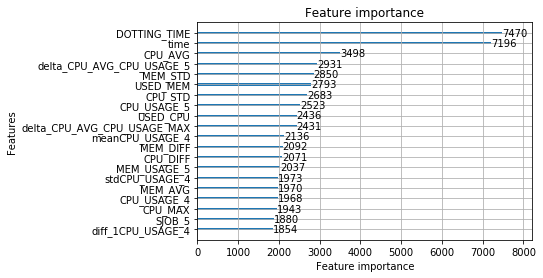

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 24.0915	valid_1's l2: 25.1578
[400]	training's l2: 21.7734	valid_1's l2: 23.7519
[600]	training's l2: 20.4507	valid_1's l2: 23.1226
[800]	training's l2: 19.505	valid_1's l2: 22.7656
[1000]	training's l2: 18.7204	valid_1's l2: 22.4659
[1200]	training's l2: 18.0676	valid_1's l2: 22.2672
[1400]	training's l2: 17.47	valid_1's l2: 22.085
[1600]	training's l2: 16.9602	valid_1's l2: 21.9588
[1800]	training's l2: 16.5126	valid_1's l2: 21.8512
[2000]	training's l2: 16.1014	valid_1's l2: 21.7489
Did not meet early stopping. Best iteration is:
[2000]	training's l2: 16.1014	valid_1's l2: 21.7489


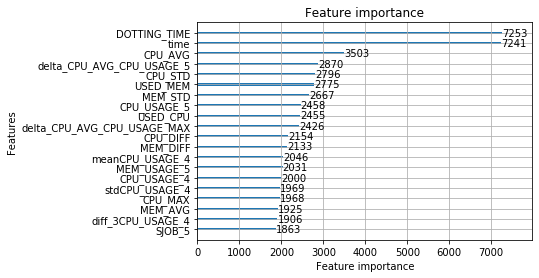

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23.7921	valid_1's l2: 25.9915
[400]	training's l2: 21.6953	valid_1's l2: 24.7299
[600]	training's l2: 20.339	valid_1's l2: 24.0264
[800]	training's l2: 19.3053	valid_1's l2: 23.5783
[1000]	training's l2: 18.5383	valid_1's l2: 23.317
[1200]	training's l2: 17.843	valid_1's l2: 23.0469
[1400]	training's l2: 17.2158	valid_1's l2: 22.8263
[1600]	training's l2: 16.6701	valid_1's l2: 22.6582
[1800]	training's l2: 16.2488	valid_1's l2: 22.5829
[2000]	training's l2: 15.8113	valid_1's l2: 22.491
Did not meet early stopping. Best iteration is:
[2000]	training's l2: 15.8113	valid_1's l2: 22.491


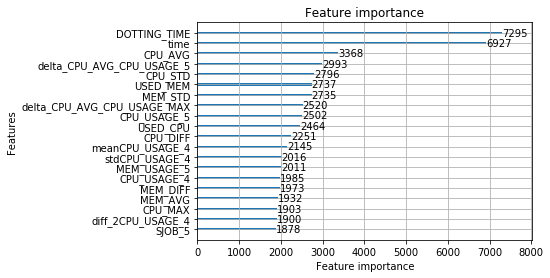

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 24.0036	valid_1's l2: 25.1248
[400]	training's l2: 21.7219	valid_1's l2: 23.7433
[600]	training's l2: 20.3721	valid_1's l2: 23.0774
[800]	training's l2: 19.3805	valid_1's l2: 22.6485
[1000]	training's l2: 18.5961	valid_1's l2: 22.3549
[1200]	training's l2: 17.9307	valid_1's l2: 22.1734
[1400]	training's l2: 17.3384	valid_1's l2: 22.0336
[1600]	training's l2: 16.8259	valid_1's l2: 21.9064
[1800]	training's l2: 16.3841	valid_1's l2: 21.8094
[2000]	training's l2: 15.9823	valid_1's l2: 21.7443
Did not meet early stopping. Best iteration is:
[2000]	training's l2: 15.9823	valid_1's l2: 21.7443


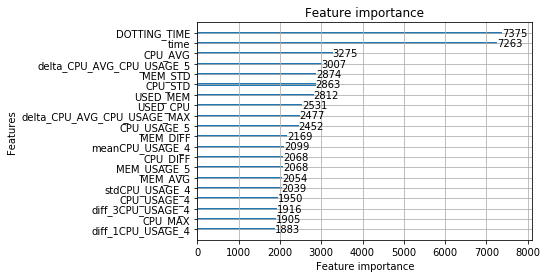

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23.7622	valid_1's l2: 25.9362
[400]	training's l2: 21.5852	valid_1's l2: 24.6792
[600]	training's l2: 20.2074	valid_1's l2: 23.9547
[800]	training's l2: 19.2774	valid_1's l2: 23.5776
[1000]	training's l2: 18.4812	valid_1's l2: 23.2643
[1200]	training's l2: 17.8467	valid_1's l2: 23.0645
[1400]	training's l2: 17.2812	valid_1's l2: 22.9116
[1600]	training's l2: 16.7813	valid_1's l2: 22.7603
[1800]	training's l2: 16.3395	valid_1's l2: 22.6456
[2000]	training's l2: 15.9464	valid_1's l2: 22.5783
Did not meet early stopping. Best iteration is:
[2000]	training's l2: 15.9464	valid_1's l2: 22.5783


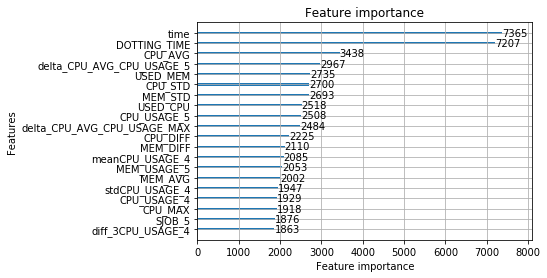

array([54.9420904 , 39.80607101, 52.93656401, ...,  1.99942335,
        4.17103701,  8.44179525])

In [49]:
sub = pd.DataFrame()
sub['time'] = new_test['time']
sub['res'] = oof_test

In [79]:
sub

,time,res
0,1,54.942090
1,1,39.806071
2,1,52.936564
3,1,16.359698
4,1,8.191600
...,...,...
14975,5,72.721693
14976,5,1.631128
14977,5,1.999423
14978,5,4.171037


In [101]:
sample_df = pd.read_csv(SAMPLE_SUBMIT)

sample_df.loc[:,'CPU_USAGE_1'] = sub[sub['time']==1]['res']
sample_df.loc[:,'CPU_USAGE_2'] = sub[sub['time']==2]['res']
# sample_df.loc[:,'CPU_USAGE_1'] = sub[sub['time']==1]['res']
# sample_df.loc[:,'CPU_USAGE_1'] = sub[sub['time']==1]['res']
# sample_df.loc[:,'CPU_USAGE_1'] = sub[sub['time']==1]['res']
# sub[sub['time']==3]['res'].reset_index(drop=True)

In [102]:

pre_col = ['CPU_USAGE_1','CPU_USAGE_2','CPU_USAGE_3','CPU_USAGE_4','CPU_USAGE_5']
for i,name in enumerate(pre_col):
    print(i+1,len(sub[sub['time']==i+1]['res']))
    sample_df.loc[:,name] = sub[sub['time']==i+1]['res'].reset_index(drop=True)
#     print('sample',name,i)


1 2996
2 2996
3 2996
4 2996
5 2996


In [103]:
sample_df
# i=3
# sub[sub['time']==i+1]['res']

,ID,CPU_USAGE_1,LAUNCHING_JOB_NUMS_1,CPU_USAGE_2,LAUNCHING_JOB_NUMS_2,CPU_USAGE_3,LAUNCHING_JOB_NUMS_3,CPU_USAGE_4,LAUNCHING_JOB_NUMS_4,CPU_USAGE_5,LAUNCHING_JOB_NUMS_5
0,1,54.942090,0,48.997697,0,42.243453,0,43.742416,0,44.829409,0
1,2,39.806071,0,40.041997,0,41.562895,0,44.293808,0,39.974094,0
2,3,52.936564,0,51.542858,0,19.842616,0,6.219792,0,4.242660,0
3,4,16.359698,0,10.207331,0,6.694358,0,4.621414,0,5.838207,0
4,5,8.191600,0,13.087920,0,14.764243,0,14.839435,0,13.689270,0
...,...,...,...,...,...,...,...,...,...,...,...
2991,2992,2.267525,0,3.401310,0,11.334874,0,46.675804,0,72.721693,0
2992,2993,31.331335,0,5.198586,0,1.405654,0,1.556575,0,1.631128,0
2993,2994,1.188252,0,1.318171,0,1.673449,0,2.060366,0,1.999423,0
2994,2995,4.219688,0,4.180951,0,4.167997,0,4.168241,0,4.171037,0


In [104]:
sample_df.describe()

,ID,CPU_USAGE_1,LAUNCHING_JOB_NUMS_1,CPU_USAGE_2,LAUNCHING_JOB_NUMS_2,CPU_USAGE_3,LAUNCHING_JOB_NUMS_3,CPU_USAGE_4,LAUNCHING_JOB_NUMS_4,CPU_USAGE_5,LAUNCHING_JOB_NUMS_5
count,2996.000000,2996.000000,2996.0,2996.000000,2996.0,2996.000000,2996.0,2996.000000,2996.0,2996.000000,2996.0
mean,1498.500000,18.971649,0.0,18.125628,0.0,17.942064,0.0,18.019223,0.0,17.747784,0.0
std,865.015029,19.971176,0.0,17.779854,0.0,16.778967,0.0,17.059433,0.0,17.009306,0.0
min,1.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.082087,0.0
25%,749.750000,3.807763,0.0,3.963486,0.0,4.015560,0.0,3.989418,0.0,3.957464,0.0
50%,1498.500000,10.605658,0.0,11.421785,0.0,12.810744,0.0,12.246654,0.0,12.042487,0.0
75%,2247.250000,29.287022,0.0,27.603759,0.0,26.913377,0.0,27.355991,0.0,26.830218,0.0
max,2996.000000,92.445398,0.0,92.251838,0.0,91.130493,0.0,89.811362,0.0,88.262380,0.0


In [39]:
Y_features = [
    'CPU_USAGE_6', 'LJOB_6',
    'CPU_USAGE_7', 'LJOB_7',
    'CPU_USAGE_8', 'LJOB_8',
    'CPU_USAGE_9', 'LJOB_9',
    'CPU_USAGE_10', 'LJOB_10'
]

Y_train = train_df[Y_features]
train_df.drop(columns=Y_features, inplace=True)
lgb_param = {
    'num_leaves': 64,
    'max_depth': 10,
    'learning_rate': 0.08,
    'n_estimators': 2000,
    'subsample': 0.6,
    'feature_fraction': 0.6,
    'reg_alpha': 0.6,
    'reg_lambda': 1.2,
    'seed': 2020  # ！！！记得修改！！！
}

  0%|          | 0/50 [00:07<?, ?it/s]


******model******:  CPU_USAGE_7
Training until validation scores don't improve for 50 rounds
[200]	valid_0's l2: 18.3743
[400]	valid_0's l2: 17.562
[600]	valid_0's l2: 17.1783
[800]	valid_0's l2: 16.9907
[1000]	valid_0's l2: 16.8567
[1200]	valid_0's l2: 16.7841
[1400]	valid_0's l2: 16.7233
[1600]	valid_0's l2: 16.6965
[1800]	valid_0's l2: 16.6439
Early stopping, best iteration is:
[1897]	valid_0's l2: 16.6361


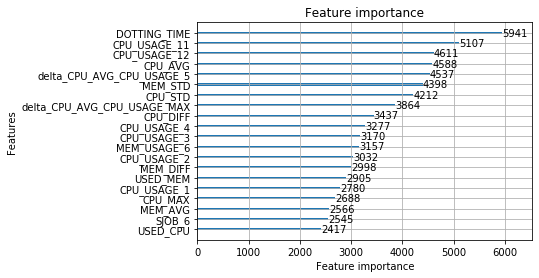

ValueError: Number of features of the model must match the input. Model n_features_ is 91 and input n_features is 89 

In [22]:
sample_df = pd.read_csv(SAMPLE_SUBMIT)
# 总迭代次数
N = MODEL_N * NFOLDS

# 进度条
pbar = tqdm(total=N, position=0, leave=True)

# 交叉验证
# kfold = KFold(n_splits=NFOLDS, shuffle=True, random_state=2020)
# kf = kfold.split(train_df)
# kfold = KFold(n_splits=5, random_state=42,shuffle=True)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
# out-of-folds
oof = np.zeros((train_df.shape[0], MODEL_N))
# for i in range(MODEL_N):
for i in [0,2,4,6,8]:
    print('******model******: ',Y_features[i])
    
    for fold_id, ( train_idx, validate_idx) in enumerate(kfold.split(train_df, Y_train.iloc[:, i])):
    # for train_idx, validate_idx in kf:
    #         print( X_train)
        # 切割训练集&验证集
        X_train, y_train = train_df.iloc[train_idx, :], Y_train.iloc[train_idx, i]
        X_valid, y_valid = train_df.iloc[validate_idx, :], Y_train.iloc[validate_idx,i]

        reg = lgb.LGBMRegressor(n_jobs=-1, **lgb_param)
        bst = reg.fit(X_train, y_train, verbose=200, eval_set=[(X_valid, y_valid)],
                      early_stopping_rounds=50)

        # 特征重要性
        lgb.plot_importance(bst, max_num_features=20)
        plt.show()
        # 验证集
        valid_pred = bst.predict(X_valid)
        valid_pred[valid_pred < 0] = 0
        valid_pred[valid_pred > 100] = 100
        valid_pred = valid_pred.astype(np.int)
        oof[validate_idx, i] = valid_pred

        # 测试集
        test_pred = bst.predict(test_df)
        test_pred[test_pred < 0] = 0
        test_pred[test_pred > 100] = 100
        sample_df.iloc[:, i+1] += test_pred / NFOLDS

    last_i = i
    # 转为整型
    sample_df = sample_df.astype(np.int)

  0%|          | 0/50 [00:00<?, ?it/s]

model:  CPU_USAGE_6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
Training until validation scores don't improve for 50 rounds
[200]	valid_0's l2: 18.8042
[400]	valid_0's l2: 18.0797
[600]	valid_0's l2: 17.8408
[800]	valid_0's l2: 17.6966
[1000]	valid_0's l2: 17.5955
Early stopping, best iteration is:
[1123]	valid_0's l2: 17.5626


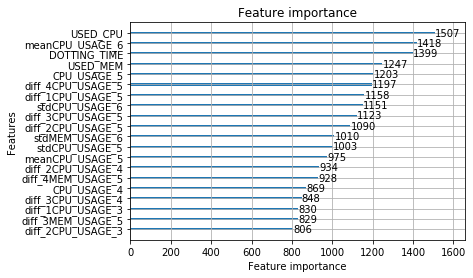

  2%|▏         | 1/50 [00:40<32:57, 40.35s/it]

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
Training until validation scores don't improve for 50 rounds
[200]	valid_0's l2: 17.9329
[400]	valid_0's l2: 17.3883
[600]	valid_0's l2: 17.1742
[800]	valid_0's l2: 17.0813
[1000]	valid_0's l2: 17.0263
[1200]	valid_0's l2: 17.0086
Early stopping, best iteration is:
[1279]	valid_0's l2: 17.0007


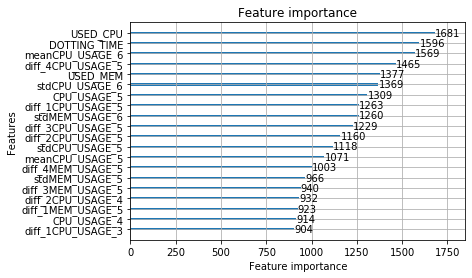

  4%|▍         | 2/50 [01:25<33:22, 41.72s/it]

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
Training until validation scores don't improve for 50 rounds
[200]	valid_0's l2: 18.8367
[400]	valid_0's l2: 18.1594
[600]	valid_0's l2: 17.9131
[800]	valid_0's l2: 17.8179
Early stopping, best iteration is:
[894]	valid_0's l2: 17.7648


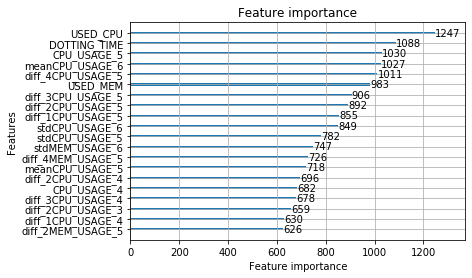

  6%|▌         | 3/50 [01:58<30:38, 39.11s/it]

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
Training until validation scores don't improve for 50 rounds
[200]	valid_0's l2: 18.676
[400]	valid_0's l2: 18.0093
[600]	valid_0's l2: 17.7655
[800]	valid_0's l2: 17.6191
[1000]	valid_0's l2: 17.5395
[1200]	valid_0's l2: 17.4983
[1400]	valid_0's l2: 17.4649
[1600]	valid_0's l2: 17.4381
Early stopping, best iteration is:
[1586]	valid_0's l2: 17.432


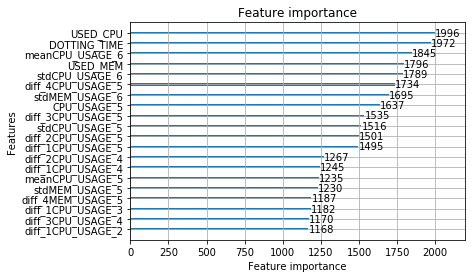

  8%|▊         | 4/50 [02:52<33:23, 43.55s/it]

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
Training until validation scores don't improve for 50 rounds
[200]	valid_0's l2: 18.3974
[400]	valid_0's l2: 17.8353
[600]	valid_0's l2: 17.6302
[800]	valid_0's l2: 17.5197
[1000]	valid_0's l2: 17.4387
Early stopping, best iteration is:
[1121]	valid_0's l2: 17.4028


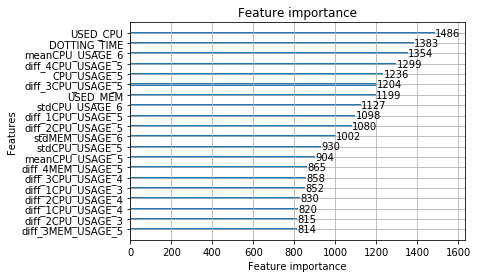

 10%|█         | 5/50 [03:33<31:57, 42.60s/it]


model:  CPU_USAGE_7
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
Training until validation scores don't improve for 50 rounds
[200]	valid_0's l2: 24.4007
[400]	valid_0's l2: 23.8557
[600]	valid_0's l2: 23.5581
[800]	valid_0's l2: 23.3669
[1000]	valid_0's l2: 23.2857
Early stopping, best iteration is:
[1030]	valid_0's l2: 23.2828


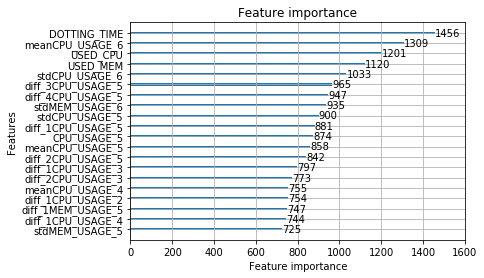

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
Training until validation scores don't improve for 50 rounds
[200]	valid_0's l2: 24.6308
[400]	valid_0's l2: 24.074
[600]	valid_0's l2: 23.8447
Early stopping, best iteration is:
[735]	valid_0's l2: 23.7322


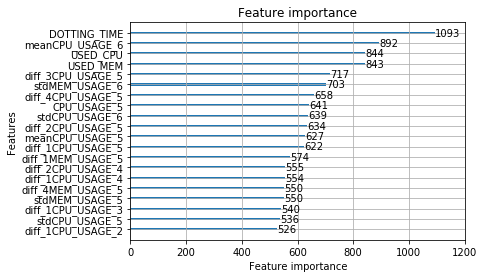

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
Training until validation scores don't improve for 50 rounds
[200]	valid_0's l2: 24.8217
[400]	valid_0's l2: 24.1072
[600]	valid_0's l2: 23.7725
[800]	valid_0's l2: 23.6309
Early stopping, best iteration is:
[789]	valid_0's l2: 23.6242


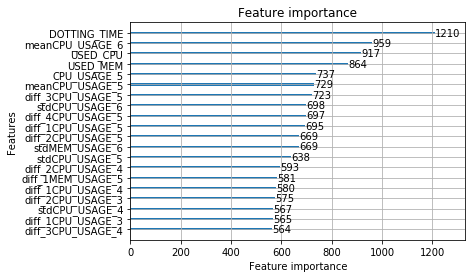

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
Training until validation scores don't improve for 50 rounds
[200]	valid_0's l2: 24.2482
[400]	valid_0's l2: 23.481
[600]	valid_0's l2: 23.1538
[800]	valid_0's l2: 22.9967
Early stopping, best iteration is:
[896]	valid_0's l2: 22.9397


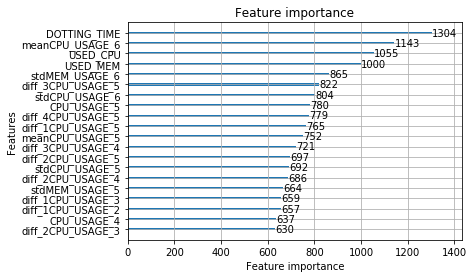

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
Training until validation scores don't improve for 50 rounds
[200]	valid_0's l2: 23.3377
[400]	valid_0's l2: 22.7331
[600]	valid_0's l2: 22.507
[800]	valid_0's l2: 22.4031
Early stopping, best iteration is:
[871]	valid_0's l2: 22.3696


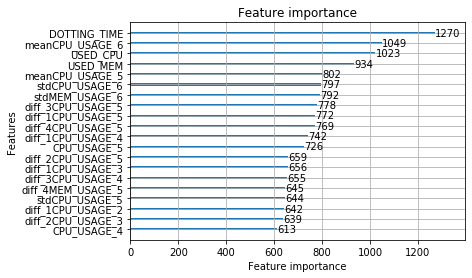

model:  CPU_USAGE_8
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
Training until validation scores don't improve for 50 rounds
[200]	valid_0's l2: 27.6818
[400]	valid_0's l2: 26.9686
[600]	valid_0's l2: 26.6944
Early stopping, best iteration is:
[632]	valid_0's l2: 26.6596


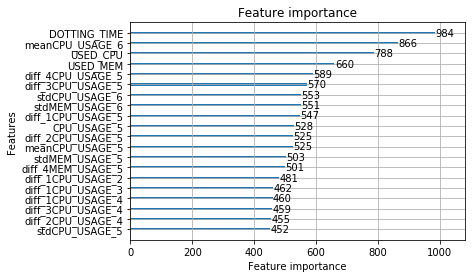

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
Training until validation scores don't improve for 50 rounds
[200]	valid_0's l2: 26.3993
[400]	valid_0's l2: 25.8526
[600]	valid_0's l2: 25.5612
[800]	valid_0's l2: 25.42
[1000]	valid_0's l2: 25.3281
Early stopping, best iteration is:
[962]	valid_0's l2: 25.3108


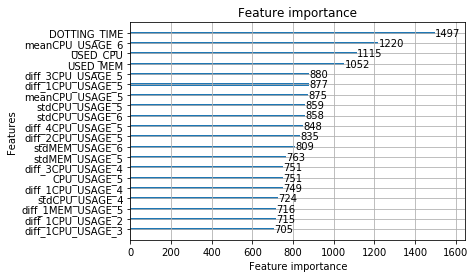

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
Training until validation scores don't improve for 50 rounds
[200]	valid_0's l2: 26.2937
[400]	valid_0's l2: 25.6628
[600]	valid_0's l2: 25.3781
[800]	valid_0's l2: 25.2213
[1000]	valid_0's l2: 25.0931
[1200]	valid_0's l2: 25.0178
Early stopping, best iteration is:
[1191]	valid_0's l2: 25.013


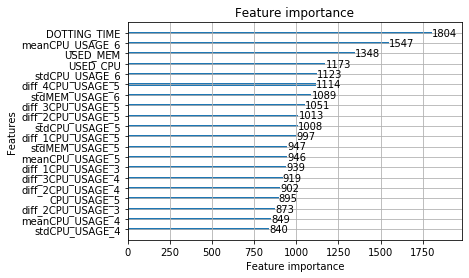

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
Training until validation scores don't improve for 50 rounds
[200]	valid_0's l2: 27.5537
[400]	valid_0's l2: 26.9722
[600]	valid_0's l2: 26.7155
[800]	valid_0's l2: 26.5248
Early stopping, best iteration is:
[836]	valid_0's l2: 26.4974


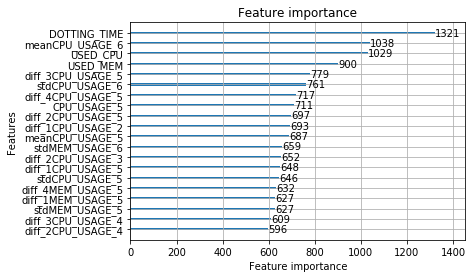

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
Training until validation scores don't improve for 50 rounds
[200]	valid_0's l2: 25.5882
[400]	valid_0's l2: 24.9357
[600]	valid_0's l2: 24.7458
[800]	valid_0's l2: 24.56
[1000]	valid_0's l2: 24.4559
Early stopping, best iteration is:
[1038]	valid_0's l2: 24.4415


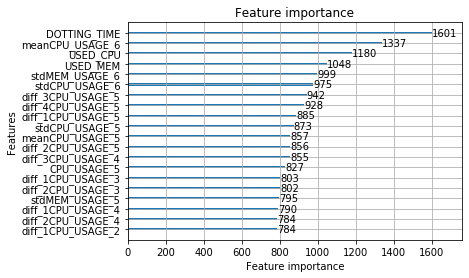

model:  CPU_USAGE_9
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
Training until validation scores don't improve for 50 rounds
[200]	valid_0's l2: 27.8973
[400]	valid_0's l2: 27.3404
[600]	valid_0's l2: 27.1637
[800]	valid_0's l2: 27.0015
Early stopping, best iteration is:
[776]	valid_0's l2: 26.9992


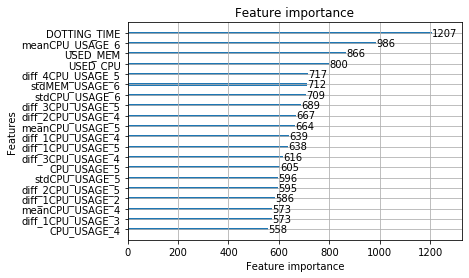

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
Training until validation scores don't improve for 50 rounds
[200]	valid_0's l2: 28.2158
[400]	valid_0's l2: 27.4475
[600]	valid_0's l2: 27.1523
[800]	valid_0's l2: 26.9714
[1000]	valid_0's l2: 26.8668
[1200]	valid_0's l2: 26.7951
Early stopping, best iteration is:
[1189]	valid_0's l2: 26.7875


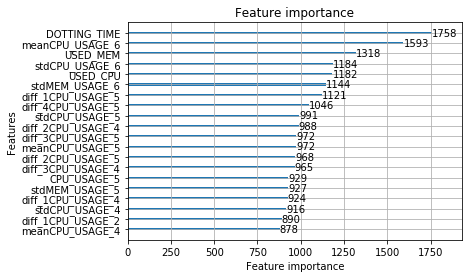

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
Training until validation scores don't improve for 50 rounds
[200]	valid_0's l2: 27.701
[400]	valid_0's l2: 27.137
[600]	valid_0's l2: 26.933
[800]	valid_0's l2: 26.7819
[1000]	valid_0's l2: 26.6962
Early stopping, best iteration is:
[1008]	valid_0's l2: 26.6884


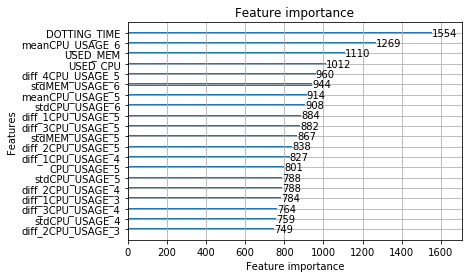

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
Training until validation scores don't improve for 50 rounds
[200]	valid_0's l2: 28.1496
[400]	valid_0's l2: 27.4456
[600]	valid_0's l2: 27.1495
[800]	valid_0's l2: 26.9954
[1000]	valid_0's l2: 26.9043
[1200]	valid_0's l2: 26.7979
Early stopping, best iteration is:
[1308]	valid_0's l2: 26.7598


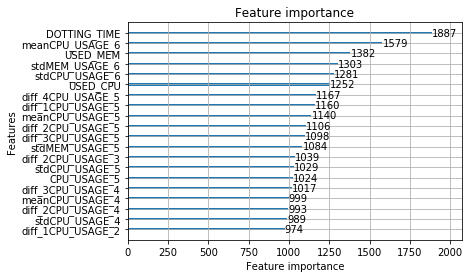

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
Training until validation scores don't improve for 50 rounds
[200]	valid_0's l2: 29.3426
[400]	valid_0's l2: 28.6689
[600]	valid_0's l2: 28.3693
[800]	valid_0's l2: 28.1445
[1000]	valid_0's l2: 28.0539
[1200]	valid_0's l2: 27.9762
Early stopping, best iteration is:
[1274]	valid_0's l2: 27.9657


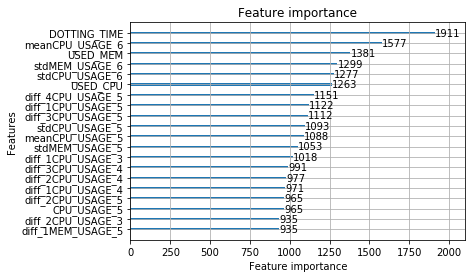

model:  CPU_USAGE_10
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
Training until validation scores don't improve for 50 rounds
[200]	valid_0's l2: 29.1587
[400]	valid_0's l2: 28.5398
[600]	valid_0's l2: 28.2053
[800]	valid_0's l2: 27.9872
[1000]	valid_0's l2: 27.8788
Early stopping, best iteration is:
[1094]	valid_0's l2: 27.8015


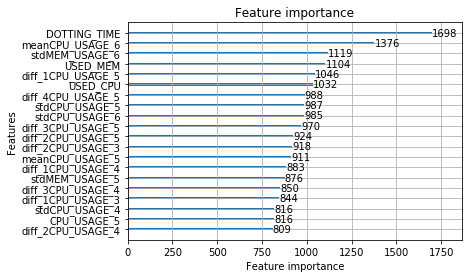

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
Training until validation scores don't improve for 50 rounds
[200]	valid_0's l2: 29.4292
[400]	valid_0's l2: 28.7369
[600]	valid_0's l2: 28.5308
[800]	valid_0's l2: 28.3399
Early stopping, best iteration is:
[834]	valid_0's l2: 28.2838


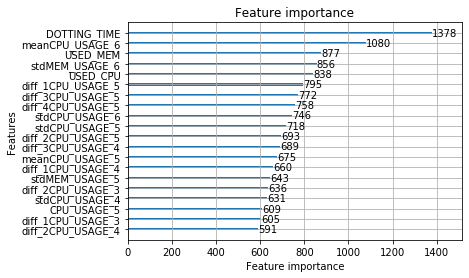

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
Training until validation scores don't improve for 50 rounds
[200]	valid_0's l2: 29.3255
[400]	valid_0's l2: 28.6673
[600]	valid_0's l2: 28.4142
[800]	valid_0's l2: 28.3113
Early stopping, best iteration is:
[843]	valid_0's l2: 28.2807


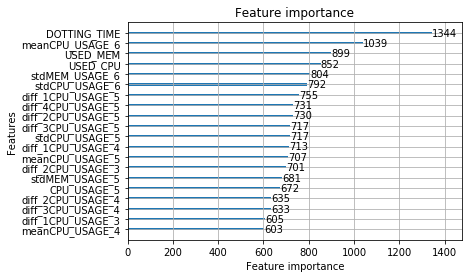

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
Training until validation scores don't improve for 50 rounds
[200]	valid_0's l2: 29.1992
[400]	valid_0's l2: 28.5713
[600]	valid_0's l2: 28.3495
[800]	valid_0's l2: 28.2368
[1000]	valid_0's l2: 28.187
[1200]	valid_0's l2: 28.1009
Early stopping, best iteration is:
[1243]	valid_0's l2: 28.0918


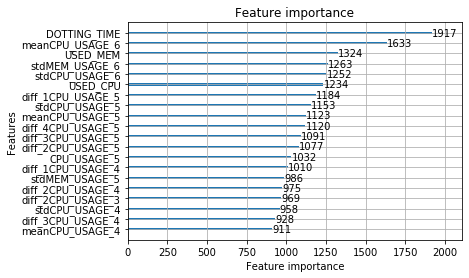

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
Training until validation scores don't improve for 50 rounds
[200]	valid_0's l2: 29.5312
[400]	valid_0's l2: 29.0453
[600]	valid_0's l2: 28.688
[800]	valid_0's l2: 28.4962
Early stopping, best iteration is:
[840]	valid_0's l2: 28.4595


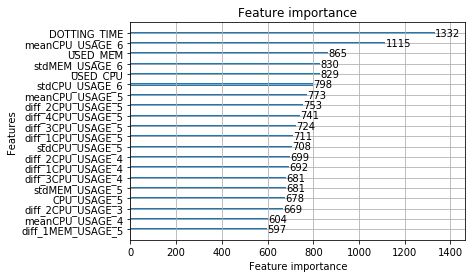

In [198]:
res = pd.DataFrame(oof[:,[0,2,4,6,8]])
res.columns = ['res_1','res_2','res_3','res_4','res_5']


,res_1,res_2,res_3,res_4,res_5
0,3.0,3.0,3.0,3.0,4.0
1,3.0,3.0,3.0,3.0,3.0
2,4.0,3.0,3.0,3.0,3.0
3,3.0,3.0,3.0,3.0,3.0
4,3.0,3.0,3.0,3.0,3.0
...,...,...,...,...,...
501295,3.0,4.0,3.0,3.0,4.0
501296,3.0,4.0,4.0,4.0,4.0
501297,3.0,3.0,3.0,3.0,3.0
501298,3.0,4.0,3.0,3.0,3.0


In [208]:
# train_df.columns[:50]

In [211]:
tmp_col_1 = ['DOTTING_TIME','USED_CPU','USED_MEM']
tmp_col_2 = ['CPU_USAGE_6',  'CPU_USAGE_7', 'CPU_USAGE_8', 'CPU_USAGE_9', 'CPU_USAGE_10']
tmp_col_3 = ['CPU_USAGE_1','CPU_USAGE_2','CPU_USAGE_3','CPU_USAGE_4','CPU_USAGE_5']
tmp = pd.concat([train_df[tmp_col_1],train_df[tmp_col_3],Y_train[tmp_col_2],res,train_df['meanCPU_USAGE_6']],axis=1)

In [126]:
# tmp.head(50)

In [ ]:
# sample_df = pd.read_csv(SAMPLE_SUBMIT)
# # 总迭代次数
# N = MODEL_N * NFOLDS

# # 进度条
# pbar = tqdm(total=N, position=0, leave=True)

# # 交叉验证
# # kfold = KFold(n_splits=NFOLDS, shuffle=True, random_state=2020)
# # kf = kfold.split(train_df)
# # kfold = KFold(n_splits=5, random_state=42,shuffle=True)
# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# # out-of-folds
# oof = np.zeros((train_df.shape[0], MODEL_N))
# for i in range(MODEL_N):
#     print('model: ',Y_features[i])
#     for fold_id, ( train_idx, validate_idx) in enumerate(kfold.split(train_df, Y_train.iloc[:, i])):
#     # for train_idx, validate_idx in kf:
# #         print( X_train)
#         # 切割训练集&验证集
#         X_train, y_train = train_df.iloc[train_idx, :], Y_train.iloc[train_idx, i]
#         X_valid, y_valid = train_df.iloc[validate_idx, :], Y_train.iloc[validate_idx,i]

#         reg = lgb.LGBMRegressor(n_jobs=-1, **lgb_param)
#         bst = reg.fit(X_train, y_train, verbose=200, eval_set=[(X_valid, y_valid)],
#                       early_stopping_rounds=50)
        
#         # 特征重要性
#         lgb.plot_importance(bst, max_num_features=20)
#         plt.show()
#         # 验证集
#         valid_pred = bst.predict(X_valid)
#         valid_pred[valid_pred < 0] = 0
#         valid_pred[valid_pred > 100] = 100
#         valid_pred = valid_pred.astype(np.int)
#         oof[validate_idx, i] = valid_pred
        
#         # 测试集
#         test_pred = bst.predict(test_df)
#         test_pred[test_pred < 0] = 0
#         test_pred[test_pred > 100] = 100
#         sample_df.iloc[:, i+1] += test_pred / NFOLDS

#         # 更新进度条
#         pbar.update(1)

# # 关闭进度条
# pbar.close()
# # 
# # 转为整型
# sample_df = sample_df.astype(np.int)

  0%|          | 0/50 [00:00<?, ?it/s]

model:  CPU_USAGE_6
Training until validation scores don't improve for 50 rounds
[200]	valid_0's l2: 18.4725
[400]	valid_0's l2: 17.8698
[600]	valid_0's l2: 17.5796
[800]	valid_0's l2: 17.516


In [105]:
def evaluate(Y_true, Y_preds):
    """赛题给的评估函数."""
    # shape: (n, 10)
    if not isinstance(Y_true, np.ndarray):
        Y_true = Y_true.to_numpy()

    if not isinstance(Y_preds, np.ndarray):
        Y_preds = Y_preds.to_numpy()

    dist = 0  # DIST_k
    for i in range(MODEL_N//2):
        cpu_true, job_true = Y_true[:, i*2], Y_true[:, i*2+1]  # shape: (n,)
        cpu_preds, job_preds = Y_preds[:, i*2], Y_preds[:, i*2+1]  # shape: (n,)
        max_job = np.max((job_true, job_preds), axis=0)

        # 防止分母为0（当分母为0是，分子也为0，所以可以把分母0设为1）
        max_job[max_job == 0] = 1.0
        dist += 0.9 * np.abs((cpu_preds - cpu_true) / 100) + 0.1 * np.abs((job_true - job_true) / max_job)

    score = 1 - dist.mean()
    return score

In [106]:
def evaluate(Y_true, Y_preds):
    """赛题给的评估函数."""
    # shape: (n, 10)
    if not isinstance(Y_true, np.ndarray):
        Y_true = Y_true.to_numpy()

    if not isinstance(Y_preds, np.ndarray):
        Y_preds = Y_preds.to_numpy()

    dist = 0  # DIST_k
#     print('Y_preds',Y_preds)
    for i in range(MODEL_N//2):
        cpu_true, job_true = Y_true[:, i*2], Y_true[:, i*2+1]  # shape: (n,)
        cpu_preds, job_preds = Y_preds[:, i*2], Y_preds[:, i*2+1]  # shape: (n,)
        max_job = np.max((job_true, job_preds), axis=0)

        # 防止分母为0（当分母为0是，分子也为0，所以可以把分母0设为1）
        max_job[max_job == 0] = 1.0
        dist += 0.9 * np.abs((cpu_preds - cpu_true) / 100) + 0.1 * np.abs((job_preds - job_true) / max_job)

    score = 1 - dist.mean()
    return score

In [155]:
# mean_oof = np.zeros((train_df.shape[0], 10))
# # list(train_df['LJOB_AVG'])
# for i in range(5): # 
#     mean_oof[:,2*i]=list(train_df['CPU_AVG'])  # + list(train_df['CPU_STD'])
#     mean_oof[:,2*i+1]=  0 #list(train_df['LJOB_AVG']) # 0# 0
# for i in range(5):
#     mean_oof[:,2*i]=list(train_df['CPU_AVG'])
#     oof[:,2*i+1]=0 # list(train_df['LJOB_AVG'])

In [108]:
# oof

In [112]:
# 计算验证集分数
oof_score = evaluate(Y_train, oof)
print('oof score = %.6f' % oof_score)  # 0.909830    0.909663  0.8838561580

oof score = 0.767769


In [114]:
sample_df.describe()

,ID,CPU_USAGE_1,LAUNCHING_JOB_NUMS_1,CPU_USAGE_2,LAUNCHING_JOB_NUMS_2,CPU_USAGE_3,LAUNCHING_JOB_NUMS_3,CPU_USAGE_4,LAUNCHING_JOB_NUMS_4,CPU_USAGE_5,LAUNCHING_JOB_NUMS_5
count,2996.000000,2996.000000,2996.0,2996.000000,2996.0,2996.000000,2996.0,2996.000000,2996.0,2996.000000,2996.0
mean,1498.500000,17.602804,0.0,16.163551,0.0,16.327437,0.0,16.213952,0.0,16.003338,0.0
std,865.015029,20.847497,0.0,17.421935,0.0,16.814432,0.0,16.636844,0.0,16.607157,0.0
min,1.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
25%,749.750000,3.000000,0.0,3.000000,0.0,4.000000,0.0,3.000000,0.0,3.000000,0.0
50%,1498.500000,8.000000,0.0,9.000000,0.0,10.000000,0.0,10.000000,0.0,10.000000,0.0
75%,2247.250000,26.000000,0.0,26.000000,0.0,26.000000,0.0,24.000000,0.0,24.000000,0.0
max,2996.000000,99.000000,0.0,99.000000,0.0,98.000000,0.0,99.000000,0.0,99.000000,0.0


In [25]:
sample_df.describe()

,ID,CPU_USAGE_1,LAUNCHING_JOB_NUMS_1,CPU_USAGE_2,LAUNCHING_JOB_NUMS_2,CPU_USAGE_3,LAUNCHING_JOB_NUMS_3,CPU_USAGE_4,LAUNCHING_JOB_NUMS_4,CPU_USAGE_5,LAUNCHING_JOB_NUMS_5
count,2996.000000,2996.000000,2996.000000,2996.000000,2996.000000,2996.000000,2996.000000,2996.000000,2996.000000,2996.000000,2996.000000
mean,1498.500000,18.632510,1.067757,17.823431,0.944259,17.514352,0.760013,17.555407,0.878505,17.426903,0.768358
std,865.015029,21.187551,7.211178,19.250043,6.275098,18.063867,4.765081,17.511568,6.195528,17.576287,4.507950
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,749.750000,3.000000,0.000000,3.000000,0.000000,3.000000,0.000000,3.000000,0.000000,3.000000,0.000000
50%,1498.500000,9.000000,0.000000,10.000000,0.000000,11.000000,0.000000,11.000000,0.000000,11.000000,0.000000
75%,2247.250000,28.000000,0.000000,28.000000,0.000000,26.000000,0.000000,27.000000,0.000000,27.000000,0.000000
max,2996.000000,99.000000,84.000000,96.000000,76.000000,92.000000,62.000000,92.000000,96.000000,95.000000,55.000000


In [24]:
sample_df.describe()

,ID,CPU_USAGE_1,LAUNCHING_JOB_NUMS_1,CPU_USAGE_2,LAUNCHING_JOB_NUMS_2,CPU_USAGE_3,LAUNCHING_JOB_NUMS_3,CPU_USAGE_4,LAUNCHING_JOB_NUMS_4,CPU_USAGE_5,LAUNCHING_JOB_NUMS_5
count,2996.000000,2996.000000,2996.000000,2996.000000,2996.000000,2996.000000,2996.000000,2996.000000,2996.000000,2996.000000,2996.000000
mean,1498.500000,18.133178,1.019693,17.435247,0.862150,16.979640,0.700935,16.999332,0.842457,16.827437,0.669226
std,865.015029,20.719785,6.938697,18.519497,5.830267,17.224413,4.645138,16.966155,6.019491,17.039322,4.232287
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,749.750000,3.000000,0.000000,3.000000,0.000000,4.000000,0.000000,4.000000,0.000000,3.000000,0.000000
50%,1498.500000,7.000000,0.000000,10.000000,0.000000,11.000000,0.000000,11.000000,0.000000,11.000000,0.000000
75%,2247.250000,26.000000,0.000000,27.000000,0.000000,25.250000,0.000000,26.000000,0.000000,26.000000,0.000000
max,2996.000000,99.000000,80.000000,99.000000,72.000000,97.000000,67.000000,98.000000,86.000000,96.000000,51.000000


In [26]:
sample_df.head()

,ID,CPU_USAGE_1,LAUNCHING_JOB_NUMS_1,CPU_USAGE_2,LAUNCHING_JOB_NUMS_2,CPU_USAGE_3,LAUNCHING_JOB_NUMS_3,CPU_USAGE_4,LAUNCHING_JOB_NUMS_4,CPU_USAGE_5,LAUNCHING_JOB_NUMS_5
0,1,82,0,68,0,44,0,40,0,77,0
1,2,36,0,34,0,40,0,44,0,34,0
2,3,52,0,61,0,17,0,15,0,9,0
3,4,23,0,5,0,7,0,8,0,5,0
4,5,1,0,10,0,11,0,8,0,6,0


In [27]:
sample_df.describe()

,ID,CPU_USAGE_1,LAUNCHING_JOB_NUMS_1,CPU_USAGE_2,LAUNCHING_JOB_NUMS_2,CPU_USAGE_3,LAUNCHING_JOB_NUMS_3,CPU_USAGE_4,LAUNCHING_JOB_NUMS_4,CPU_USAGE_5,LAUNCHING_JOB_NUMS_5
count,2996.000000,2996.000000,2996.000000,2996.000000,2996.000000,2996.000000,2996.000000,2996.000000,2996.000000,2996.000000,2996.000000
mean,1498.500000,18.405207,1.076101,17.484980,0.802737,16.978638,0.645527,16.846462,0.884179,16.785381,0.687917
std,865.015029,21.490737,7.215284,18.827025,5.368505,17.476363,4.196172,16.930452,6.450241,16.897047,4.256124
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,749.750000,3.000000,0.000000,3.000000,0.000000,4.000000,0.000000,3.000000,0.000000,3.000000,0.000000
50%,1498.500000,7.000000,0.000000,9.000000,0.000000,10.000000,0.000000,11.000000,0.000000,11.000000,0.000000
75%,2247.250000,27.000000,0.000000,27.000000,0.000000,26.000000,0.000000,26.000000,0.000000,25.000000,0.000000
max,2996.000000,99.000000,82.000000,99.000000,61.000000,99.000000,61.000000,98.000000,88.000000,97.000000,60.000000


In [110]:
sample_df = sample_df.astype(np.int)

In [111]:
sample_df.to_csv('baseline_311_cmodel.csv', index=False)

In [29]:
# sample_df

In [27]:
sample_df.to_csv('../submit/baseline_311.csv', index=False)

In [ ]:

# # 行内统计特征
# # 行内统计特征
# def stat_feat(data,step,col):
# #     print(step)
#     data['mean'+col+'_'+str(step)] = data[[f'{col}_{i}' for i in range(1,step)]].mean(axis=1)
#     data['std'+col+'_'+str(step)] = data[[f'{col}_{i}' for i in range(1,step)]].std(axis=1)
#     data['max'+col+'_'+str(step)] = data[[f'{col}_{i}' for i in range(1,step)]].max(axis=1)
#     if step < 6:
#         data['diff_1'+col+'_'+str(step)] = data[f'{col}_{step}'] - data[f'{col}_1']
#         if step  > 2:
#             data['diff_2'+col+'_'+str(step)] = data[f'{col}_{step}'] - data[f'{col}_2']
#         if step > 3:    
#             data['diff_3'+col+'_'+str(step)] = data[f'{col}_{step}'] - data[f'{col}_3']
#         if step > 4:   
#             data['diff_4'+col+'_'+str(step)] = data[f'{col}_{step}'] - data[f'{col}_4']

#     if (step >1) & (step < 6):
#         data['diff'+col+str(step)+str(step-1)] = data[f'{col}_{step}'] - data[f'{col}_{step-1}']
#     return data    
# #,'LJOB','RJOB','SJOB','CJOB', 'FJOB',
# for c in tqdm(['MEM_USAGE','CPU_USAGE','DISK_USAGE']):
#     for s in range(2,6):
#         train_df = stat_feat(train_df,s,c)
#         test_df = stat_feat(test_df,s,c)


In [ ]:
# 349
lgb_param = {
    'num_leaves': 64,
    'max_depth': 10,
    'learning_rate': 0.08,
    'n_estimators': 2500, # 20000
    'subsample': 0.6,
    'feature_fraction': 0.6,
    'reg_alpha': 0.6,
    'reg_lambda': 1.2,
    'seed': 666  # ！！！记得修改！！！2020
}
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=10) # 1
oof = np.zeros((new_train.shape[0]))
oof_test = np.zeros((new_test.shape[0]))

for fold_id, ( train_idx, validate_idx) in enumerate(kfold.split(new_train, new_train['hour'])):
# for train_idx, validate_idx in kf:
#         print( X_train)
    # 切割训练集&验证集
    X_train, y_train = new_train[trn_col].iloc[train_idx, :], new_train['cpu'].iloc[train_idx]
    X_valid, y_valid = new_train[trn_col].iloc[validate_idx, :], new_train['cpu'].iloc[validate_idx]

    reg = lgb.LGBMRegressor(n_jobs=-1, **lgb_param)
    bst = reg.fit(X_train, y_train, verbose=200, eval_set=[(X_train, y_train),(X_valid, y_valid)],
                  early_stopping_rounds=50)

    # 特征重要性
    lgb.plot_importance(bst, max_num_features=20)
    plt.show()
    # 验证集
    valid_pred = bst.predict(X_valid)
    valid_pred[valid_pred < 0] = 0
    valid_pred[valid_pred > 100] = 100
    valid_pred = valid_pred.astype(np.int)
    oof[validate_idx] = valid_pred

    # 测试集
    test_pred = bst.predict(new_test[trn_col])
    test_pred[test_pred < 0] = 0
    test_pred[test_pred > 100] = 100
    oof_test += test_pred / NFOLDS
score_mse = mean_squared_error(new_train['cpu'], oof)
print('score_mse=',score_mse)